In [1]:
import networkx as nx
import math
import numpy as np
#https://networkx.org/documentation/stable/tutorial.html

In [2]:
from functions_library import * 

def mySolve(G):
    n = len(G.nodes)
    k = math.log(n,10)
    for i in range(n):
        distances = nx.floyd_warshall(G, weight='weight')
        farthest_node = int(max(distances[i], key=distances[i].get))
        if farthest_node > k:
            G.add_edge(i,farthest_node)
    pos = nx.circular_layout(G)
    nx.draw(G,pos=pos)
    return(G)
    #subG = G.subgraph(range(v,farthest_node+1))

IndentationError: expected an indented block (functions_library.py, line 96)

# Binary Search

In [6]:
# demand-aware binary search
def construct_binary_search(G):
    """constructs edges to enable binary search
    
    Args: 
        G: Graph in Ring (or any structure)
        
    Returns:
        G: Graph, with edges for binary search
    """
    for i in range(len(G.nodes)):
        binaryGUID = list(intToBin(i,len(G.nodes)))
        for j in range(1,len(binaryGUID)+1):
            binaryGUID = list(intToBin(i,len(G.nodes)))
            binaryGUID[-j] = str((int(binaryGUID[-j]) + 1) % 2)
            peer = binToInt(binaryGUID,len(G.nodes))
            G.add_edge(i,peer)
    return G


def construct_demand_aware_binary_search(G,demandMatrix):
    """Constructs edges in a ring graph, to enable demand aware binary search"""
    copyDemandMatrix = demandMatrix
    
    maxEdge = np.argmax(copyDemandMatrix)
    #convert index to position
    row = math.floor(maxEdge/len(copyDemandMatrix))
    col = maxEdge % len(copyDemandMatrix)
    
    # If demand the same for all, do binary search
    if copyDemandMatrix[row][col] == round(1/(len(copyDemandMatrix)*(len(copyDemandMatrix)-1)),8):
        construct_binary_search(G)
        return G
    
    listOfNodes = list(G.nodes) 
    k = math.floor(math.log(len(listOfNodes),2))
    
    # Rearrange binary search to upgrade graph
    for i in range(len(copyDemandMatrix)):
        #copyDemandMatrix[i][1:len(copyDemandMatrix)-1]
        lastEdge = (i+math.ceil(len(copyDemandMatrix)/2)-1) % len(copyDemandMatrix)
        G.add_edge(i,lastEdge)
        
        frontNode = i
        backNode = len(G.nodes)-1 + (i % len(G.nodes)) +1
        for j in range(2,k):
            costFront = calc_totalTrafficCost_single_node(i,listOfNodes[frontNode:lastEdge+1],demandMatrix,G)
            costBack = calc_totalTrafficCost_single_node(i,listOfNodes[lastEdge:backNode],demandMatrix,G)
            if costFront > costBack:
                backNode = lastEdge
                lastEdge = lastEdge-math.ceil(len(listOfNodes)/(2**j))
                G.add_edge(i,lastEdge)
            else:
                frontNode = lastEdge
                lastEdge = lastEdge+math.floor(len(listOfNodes)/(2**j))
                
                G.add_edge(i,lastEdge)
    return G


# Testing

[0, 1, 2, 3, 4, 5, 6, 7]
8


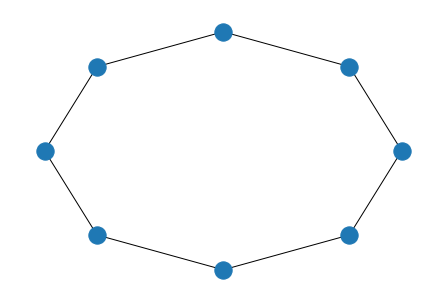

In [7]:
# Init size for Ring, 2^k
k = 3
G = init_ring(2**k)
D = init_demand_matrix(G)
#print(demandMatrix)

1.4285712000000015

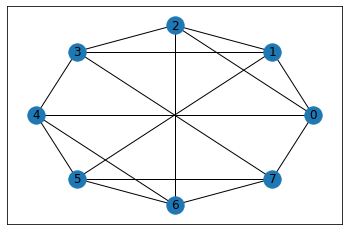

In [8]:
#demandMatrix[4][15] = 1
G = construct_demand_aware_binary_search(G,D)
pos = nx.circular_layout(G)
nx.draw_networkx(G,pos=pos,with_labels=True)
calc_cost(G,D)

In [9]:
print(calc_totalTrafficCost_single_node(i,listOfNodes[1:10],demandMatrix,G))

NameError: name 'i' is not defined

In [ ]:
demandMatrix[0][1] = 1
print(construct_binary_search(G))
print(~-1)

In [ ]:
#Testing
print(G.number_of_edges(),2**(k+1))

#Test if every node can reach every other in max. log(n) hops
distances = nx.floyd_warshall(G, weight='weight')
for i in range(2**k):
    maxKey = max(distances[i], key=distances[i].get)
    tempMax = distances[i][maxKey]
print(k >= tempMax,tempMax)


# Proof

In [ ]:
def init_matrix(k):
    n = 2**k
    matr_graph = []
    
    temp = []
    temp.append(bin(1),bin(n))
    temp.append(['0b' + ''])
    matr_graph.append((bin(0),[bin(1),bin(n)]))
    
    
    for i in range(1,n-1):
        temp = []
        temp.append(bin(i))
        temp.append(bin(i-1))
        temp.append(bin(i+1))
        matr_graph.append((temp[0],temp[1:]))
    print(matr_graph)

In [ ]:
init_matrix(3)

In [ ]:
bin(7)